In [2]:
import sys
sys.path.append('../..')
sys.path.append('../../APDFT')
sys.path.append('../../helper_code')
sys.path.append('../data')

import pickle
from pyscf import gto, scf, dft, cc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import basis_set_exchange as bse
from APDFT.FcMole import *
import os
import ast
from copy import deepcopy
from IPython.display import display
from helper_code.data_processing import *


%load_ext autoreload
%autoreload 2
from APDFT.AP_class import APDFT_perturbator as AP

## DFT, Hessian, ANM ##

No need to run these cells if Hessian is already calculated

In [2]:
# Specify the atomic coordinates of benzene molecule (the reference molecule for ANM calculations)

benz_atom="""
C        1.71265808       0.13276268       0.00006550
C        3.09975708       0.13269330       0.00049236
C        3.79340809       1.33390518      -0.00006494
C        3.09987779       2.53518655      -0.00105701
C        1.71277873       2.53525598      -0.00147341
C        1.01912772       1.33404402      -0.00091748
H        1.17120884      -0.80500514       0.00050085
H        3.64111213      -0.80512867       0.00125839
H        4.87626010       1.33385102       0.00026564
H        3.64132705       3.47295440      -0.00149649
H        1.17142366       3.47307800      -0.00223754
H       -0.06372432       1.33409819      -0.00124687
"""

In [3]:
basis_pcx2={"H":"pc-2",'C':bse.get_basis("pcX-2",fmt="nwchem",elements=[6])\
           ,'N':bse.get_basis("pcX-2",fmt="nwchem",elements=[7])\
           ,'O':bse.get_basis("pcX-2",fmt="nwchem",elements=[8])}

In [4]:
mol = gto.M(atom=benz_atom, basis=basis_pcx2, unit='Angstrom')
# run DFT calculation
mol_DFT = scf.RKS(mol)
mol_DFT.xc = "PBE0" # specify the exchange-correlation functional used for DFT
mol_DFT.kernel(verbose=False) # run self-consistent field calculation
mol_total_energy = mol_DFT.energy_tot()
mol_electronic_energy = mol_DFT.energy_elec()
print("Total energy:", mol_total_energy)
print("Electronic energy (electronic energy, nuclear repulsion energy):", mol_electronic_energy) 

converged SCF energy = -232.053033860332
Total energy: -232.0530338603313
Electronic energy (electronic energy, nuclear repulsion energy): (-436.54061530520573, 279.7181026946837)


In [3]:
grad_and_hessian = np.load("../data/benzene_raw_data/benzene_correct_hessian.npz", allow_pickle=True)
g, H = grad_and_hessian['g'], grad_and_hessian['H']
print(g.shape)
print(H.shape)

(6,)
(6, 6)


In [4]:
Q_eig_val, Q = np.linalg.eig(H)
np.savetxt('CCS_basis/ANM_basis.txt', Q)
H_df = pd.DataFrame(H)
Q_df = pd.DataFrame(Q)
print(Q_eig_val)
display(H_df)
display(Q_df)

[-1.96476956 -3.46253538 -3.28728604 -3.28729005 -3.39061277 -3.39061371]


,0,1,2,3,4,5
0,-3.130517,0.266849,0.208433,0.215186,0.208432,0.266848
1,0.266849,-3.130517,0.266848,0.208432,0.215186,0.208433
2,0.208433,0.266848,-3.130519,0.266848,0.208433,0.215186
3,0.215186,0.208432,0.266848,-3.130517,0.266849,0.208433
4,0.208432,0.215186,0.208433,0.266849,-3.130517,0.266848
5,0.266848,0.208433,0.215186,0.208433,0.266848,-3.130519


,0,1,2,3,4,5
0,-0.408249,0.408248,0.499761,-0.289089,0.499846,-0.288941
1,-0.408249,-0.408248,0.500239,0.288261,-0.500154,-0.288409
2,-0.408248,0.408249,0.000478,0.577350,0.000307,0.577351
3,-0.408249,-0.408248,-0.499761,0.289089,0.499846,-0.288941
4,-0.408249,0.408248,-0.500239,-0.288261,-0.500153,-0.288409
5,-0.408248,-0.408249,-0.000478,-0.577350,0.000307,0.577350


## Load Data ##

In [5]:
energy_data = np.load("../data/benzene_raw_data/Benzene_BNdoping_PBE0_pcX2_correct.npz", allow_pickle=True)
all_keys = list(energy_data.keys())
print(all_keys)

['charges', 'coords', 'elements', 'energies']


In [6]:
charges, total_energy = energy_data['charges'], energy_data['energies']
columns = ['charges', 'total energy']
benzene_energy_data = pd.DataFrame(columns=columns)
benzene_energy_data['charges'] = charges.tolist()
benzene_energy_data['total energy'] = total_energy.tolist()

BENZ_REFERENCE_ENERGY = -232.053033860332 # mol_total_energy
benzene_energy_data['delta total energy'] = benzene_energy_data['total energy'].apply(lambda x: BENZ_REFERENCE_ENERGY-x)

benzene_energy_data['dx'] = None
benzene_energy_data['APDFT2'] = None
benzene_energy_data['DD e_tot'] = None
benzene_energy_data['DD e_tot (kcal/mol)'] = None
HA_TO_KCAL = 627.5096080305927
for index, row in benzene_energy_data.iterrows():
    ref_charge = np.array([6, 6, 6, 6, 6, 6])
    dx = np.array(row['charges'][:6]) - ref_charge
    apdft2 = BENZ_REFERENCE_ENERGY + dx.dot(g) + 0.5*np.einsum('i,ij,j', dx, H ,dx)
    target_energy = benzene_energy_data.at[index, 'total energy']
    benzene_energy_data.at[index, 'dx'] = dx
    benzene_energy_data.at[index, 'APDFT2'] = apdft2
    benzene_energy_data.at[index, 'DD e_tot'] = apdft2 - target_energy
    benzene_energy_data.at[index, 'DD e_tot (kcal/mol)'] = benzene_energy_data.at[index, 'DD e_tot'] * HA_TO_KCAL

display(benzene_energy_data.head(3))

,charges,total energy,delta total energy,dx,APDFT2,DD e_tot,DD e_tot (kcal/mol)
0,"[7, 5, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]",-235.451648,3.398614,"[1, -1, 0, 0, 0, 0]",-235.4504,0.001247,0.78259
1,"[7, 6, 5, 6, 6, 6, 1, 1, 1, 1, 1, 1]",-235.394261,3.341228,"[1, 0, -1, 0, 0, 0]",-235.39198,0.002282,1.431932
2,"[7, 6, 6, 5, 6, 6, 1, 1, 1, 1, 1, 1]",-235.401935,3.348901,"[1, 0, 0, -1, 0, 0]",-235.398737,0.003198,2.007018


In [2]:
from qml.kernels import get_local_kernel_mbdf

ImportError: cannot import name 'get_local_kernel_mbdf' from 'qml.kernels' (/home/gabrielwu2004/.local/lib/python3.10/site-packages/qml/kernels.py)

In [1]:
from qml.kernels import 


ImportError: cannot import name 'extended_gaussian_kernel' from 'qml.kernels' (/home/gabrielwu2004/.local/lib/python3.10/site-packages/qml/kernels.py)

7.23853427807126
12.705716653144094


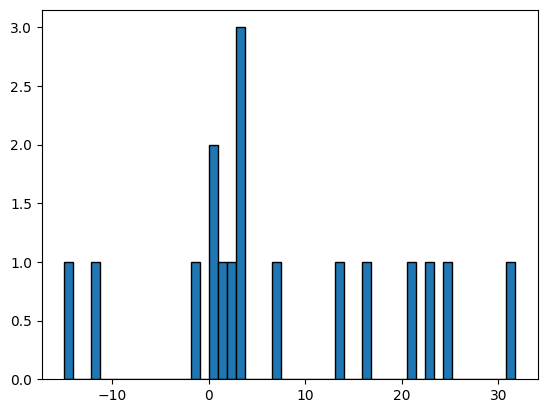

In [7]:
print(np.array(benzene_energy_data['DD e_tot (kcal/mol)'].mean()))
print(np.array(benzene_energy_data['DD e_tot (kcal/mol)'].std()))
plt.hist(benzene_energy_data['DD e_tot (kcal/mol)'].tolist(), bins=50, edgecolor='black')
plt.show()

## ANM Representation ##

In [8]:
benzene_energy_data['dx_lexi'] = benzene_energy_data['dx'].apply(
    lambda arr: lexi_transformation(arr))

benzene_energy_data['c'] = benzene_energy_data['dx'].apply(
    lambda arr: (np.array(arr).reshape(1, 6) @ Q).reshape(6,).tolist()) # column vector view: c = Q_inv @ dx

benzene_energy_data['c_lexi'] = benzene_energy_data['dx_lexi'].apply(
    lambda arr: (np.array(arr).reshape(1, 6) @ Q).reshape(6,).tolist())

benzene_energy_data['CE'] = benzene_energy_data['c'].apply(
    lambda arr: compute_lambda_c(arr, Q_eig_val))

benzene_energy_data['CE_lexi'] = benzene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c(arr, Q_eig_val))

benzene_energy_data['CSE'] = benzene_energy_data['c'].apply(
    lambda arr: compute_lambda_c_square(arr, Q_eig_val))

benzene_energy_data['CSE_lexi'] = benzene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c_square(arr, Q_eig_val))


2.246498111850073
3.606542192026685


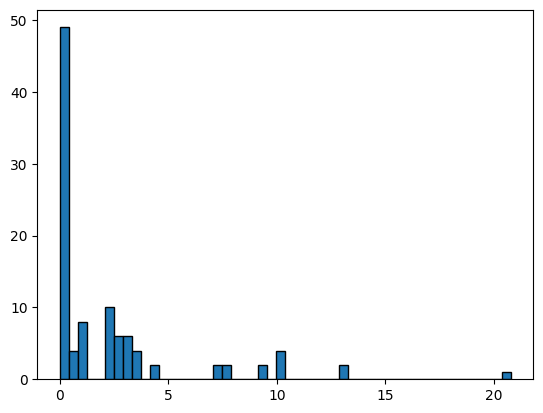

In [9]:
C = np.vstack(benzene_energy_data['CSE_lexi'].tolist()).flatten()
print(C.mean())
print(C.std())
plt.hist(C, bins=50, edgecolor='black')
plt.show()

## Export Training Data ##

In [10]:
datasets = ['c', 'c_lexi', 'CE', 'CE_lexi', 'CSE', 'CSE_lexi']
columns = [f"coord{i}" for i in range(6)]

dataset_dict = {}
for data in datasets:
    dataset_dict[data] = pd.DataFrame(columns=columns)
    for i in range(6):
        dataset_dict[data][f"coord{i}"] = benzene_energy_data[data].apply(lambda arr: arr[i])

for key, dataframe in dataset_dict.items():
    dataframe.to_csv(f'../data/benzene_training_data/[Benz]_{key}.csv', index=False)

In [11]:
benzene_energy_data['DD e_tot (kcal/mol)'].to_csv('../data/benzene_training_data/DD_e_tot (kcal).csv', index=False)